In [1]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import statsmodels.api as sm
import getstock
import os

apikey = "xxx"
apikey_zzl = "xxx"
apikey_st = "xxx"

### Geting the stock name from S&P500

In [2]:
import xlrd
def readExcelFile(filename):
    # 打开工作表
    workbook = xlrd.open_workbook(filename=filename)
    # 用索引取第一个工作薄
    booksheet = workbook.sheet_by_index(0)
    Stocks_Name = []
    # 返回的结果集
    for i in range(1,506):
        Stocks_Name.append(booksheet.row_values(i)[0])
        # print(i,": ",booksheet.row_values(i)[0])
    return Stocks_Name
Stocks_Name = readExcelFile("./SP_Stocks.xlsx")

### Geting stocks and sp500

In [3]:
def Exist(symbol):
    path = './stocks505/' + symbol + '_monthly.csv'
    if os.path.exists(path):
        return True
    else:
        return False
    return False
def getStocksLocally(Stocks_name):
    Stocks = {}
    for stock_symbol in Stocks_name:
#         if(stock_symbol=="CARR" or stock_symbol=="OTIS" or stock_symbol=="AMCR" or stock_symbol=="CBRE"):
#             continue
        path = './stocks505/' + stock_symbol + '_monthly.csv'
        if(Exist(stock_symbol)):
            # print(stock_symbol, end=" ")
            with open(path, mode='r', encoding='utf-8') as f:
                per = pd.read_csv(f)
                NEW_timeStamp = pd.to_datetime(per['Unnamed: 0'])
                per.index = NEW_timeStamp
                per.index.name = "timestamp"
                per = per.drop(columns = {'Unnamed: 0'})
                per = per.loc['2015':'2019']
                if(len(per)!=60):
                    continue
                Stocks[stock_symbol] = per
    return Stocks
def getIndex():
    columns = [ 'open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'dividend_amt']
    # get the market index of ^GSPC
    GSPC_index = getstock.getMonthlyStockPrices("^GSPC", apikey)
    GSPC_index.columns = columns
    GSPC_index = GSPC_index.sort_values('timestamp', ascending=True).loc['2015':'2019']
    return GSPC_index
Stocks = getStocksLocally(Stocks_Name)
GSPC_index = getIndex()
# GSPC_index.index.name = None
display(GSPC_index.tail())

LocalData:


,open,high,low,close,adjusted_close,volume,dividend_amt
timestamp,,,,,,,
2019-08-30,2980.3201,3013.5901,2822.1201,2926.4600,2926.4600,79599440000,0.0
2019-09-30,2909.0100,3021.9900,2891.8501,2976.7400,2976.7400,73992330000,0.0
2019-10-31,2983.6899,3050.1001,2855.9399,3037.5601,3037.5601,77564550000,0.0
2019-11-29,3050.7200,3154.2600,3050.7200,3140.9800,3140.9800,72179920000,0.0
2019-12-31,3143.8501,3247.9299,3070.3301,3230.7800,3230.7800,72054000000,0.0


### Geting riskfree

In [4]:
tbill_data = pd.read_excel('../../General Resources/tbilldata.xlsx', skiprows=1) # skiprows=1 跳过第一行
tbill_data.index = pd.to_datetime(tbill_data['DATE'])                            # DATE column 转化成 index
tbill_data = tbill_data.drop('DATE', axis=1)                                     # 再删去DATE这个column
_15_19_byYear = tbill_data.loc['2015':'2019']['BANK DISCOUNT.2']
Sum = []
for year in range(2015,2020):
    Sum.append((_15_19_byYear.loc[str(year)]/100).mean()) 
avg_annual = np.mean(Sum)
print("avg_annual", avg_annual)
Monthly_risk_free = avg_annual/12
print("Monthly_risk_free", Monthly_risk_free)

avg_annual 0.010698813575433277
Monthly_risk_free 0.0008915677979527731


### Geting Alpha

In [39]:
def getInterceptSlope(stock_ret, index_ret):
    model_data = pd.concat([stock_ret, index_ret], axis=1)
    model_data.columns = ['stock_ret', 'index_ret']
#     display(model_data.head())
    # fit the data with ols model
    results = smf.ols('stock_ret ~ index_ret', data=model_data).fit()
    intercept = results.params.Intercept
    slope = results.params.index_ret
    rsquared = results.rsquared
    return intercept, slope, rsquared
def getRiskfree_1_beta(Rf, slope_name, Slopes):
    return Rf*(1-Slopes[slope_name])
def getSingleAlpha(Intercepts,Rf_1_beta):
    return Intercepts-Rf_1_beta
def getAlphas(stocks, index, Rf):
    Intercepts = {}
    Slopes = {}
    rsquareds = {}
    index_ret = ((index.close.diff() + index.dividend_amt.shift())/index.close.shift()).bfill()
    for stock in stocks:
        stock_ret = ((stocks[stock].close.diff() + stocks[stock].dividend_amt.shift())/stocks[stock].close.shift()).bfill()
        I_S = getInterceptSlope(stock_ret, index_ret)
        Intercepts[stock] = I_S[0]
        Slopes[stock] = I_S[1]
        rsquareds[stock] = I_S[2]
    Rf_1_beta = {}
    for slope_name in Slopes:
        Rf_1_beta[slope_name] = getRiskfree_1_beta(Rf, slope_name, Slopes)
    Alphas = {}
    for name in Intercepts:
        Alphas[name] = getSingleAlpha(Intercepts[name],Rf_1_beta[name])
    return Alphas, rsquareds
Alphas, rsquareds = getAlphas(Stocks, GSPC_index, Monthly_risk_free)

In [40]:
max_alpha = -1
max_alpha_name = 0
min_alpha = 1
min_alpha_name = 0
for alpha in Alphas:
    if(Alphas[alpha]>max_alpha):
        max_alpha = Alphas[alpha]
        max_alpha_name = alpha
    if(Alphas[alpha]<min_alpha):
        min_alpha = Alphas[alpha]
        min_alpha_name = alpha
print("min_alpha:", min_alpha_name, ":", min_alpha, "annual excess return:", (1+min_alpha)**12-1)
print("max_alpha:", max_alpha_name, ":", max_alpha, "annual excess return:", (1+max_alpha)**12-1)

max_rsquared = -1
max_rsquared_name = 0
min_rsquared = 1
min_rsquared_name = 0
for rsquared in rsquareds:
    if(rsquareds[rsquared]>max_rsquared):
        max_rsquared = rsquareds[rsquared]
        max_rsquared_name = rsquared
    if(rsquareds[rsquared]<min_rsquared):
        min_rsquared = rsquareds[rsquared]
        min_rsquared_name = rsquared
print("min_rsquared:",min_rsquared_name, ":", min_rsquared)
print("max_rsquared:",max_rsquared_name, ":", max_rsquared)

min_alpha: HBI : -0.027197615160351105 annual excess return: -0.2817171133835983
max_alpha: XRX : 0.04446442315931073 annual excess return: 0.6854808327225679
min_rsquared: DUK : 1.5945826779772965e-05
max_rsquared: HON : 0.6987161635840791


### regression plot

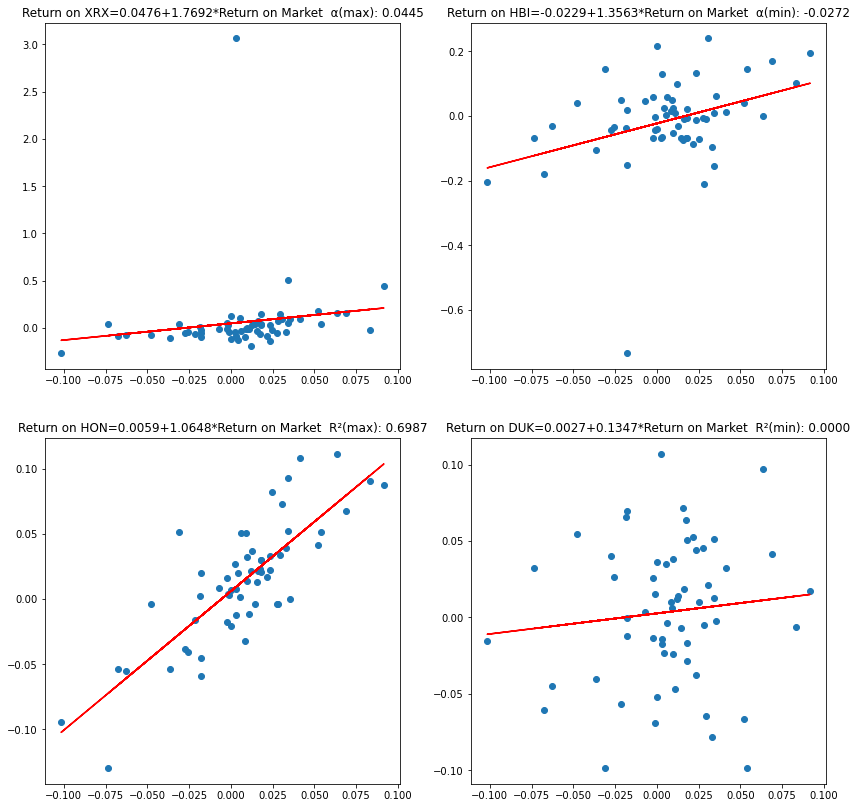

In [44]:
fig1, ax = plt.subplots(2, 2, figsize=(14,14))
index_ret = (GSPC_index.close - GSPC_index.open + GSPC_index.dividend_amt)/GSPC_index.open

# stock with max_alpha
stock_ret = ((Stocks[max_alpha_name].close.diff() + Stocks[max_alpha_name].dividend_amt.shift()\
             )/Stocks[max_alpha_name].close.shift()).bfill()
ISR = getInterceptSlope(stock_ret, index_ret)
ax[0,0].scatter(index_ret, stock_ret)
ax[0,0].plot(index_ret, ISR[0]+ISR[1]*index_ret, "r")
ax[0,0].title.set_text("Return on "+max_alpha_name+"={:.4f}+{:.4f}*Return on Market".format(ISR[0],ISR[1])\
                       +"  α(max): {:.4f}".format(max_alpha))

# stock with min_alpha
stock_ret = ((Stocks[min_alpha_name].close.diff() + Stocks[min_alpha_name].dividend_amt.shift()\
             )/Stocks[min_alpha_name].close.shift()).bfill()
ISR = getInterceptSlope(stock_ret, index_ret)
ax[0,1].scatter(index_ret, stock_ret)
ax[0,1].plot(index_ret, ISR[0]+ISR[1]*index_ret, "r")
ax[0,1].title.set_text("Return on "+min_alpha_name+"={:.4f}+{:.4f}*Return on Market".format(ISR[0],ISR[1])\
                       +"  α(min): {:.4f}".format(min_alpha))

# stock with max_rsquared
stock_ret = ((Stocks[max_rsquared_name].close.diff() + Stocks[max_rsquared_name].dividend_amt.shift()\
             )/Stocks[max_rsquared_name].close.shift()).bfill()
ISR = getInterceptSlope(stock_ret, index_ret)
ax[1,0].scatter(index_ret, stock_ret)
ax[1,0].plot(index_ret, ISR[0]+ISR[1]*index_ret, "r")
ax[1,0].title.set_text("Return on "+max_rsquared_name+"={:.4f}+{:.4f}*Return on Market".format(ISR[0],ISR[1])\
                       +"  R²(max): {:.4f}".format(max_rsquared))

# stock with min_rsquared
stock_ret = ((Stocks[min_rsquared_name].close.diff() + Stocks[min_rsquared_name].dividend_amt.shift()\
             )/Stocks[min_rsquared_name].close.shift()).bfill()
ISR = getInterceptSlope(stock_ret, index_ret)
ax[1,1].scatter(index_ret, stock_ret)
ax[1,1].plot(index_ret, ISR[0]+ISR[1]*index_ret, "r")
ax[1,1].title.set_text("Return on "+min_rsquared_name+"={:.4f}+{:.4f}*Return on Market".format(ISR[0],ISR[1])\
                       +"  R²(min): {:.4f}".format(min_rsquared))

plt.show()

# # store in local catalog
# Stocks[max_alpha_name].to_csv(str(Stocks_Name[max_alpha_name])+"_max_alpha.csv")
# Stocks[min_alpha_name].to_csv(str(Stocks_Name[min_alpha_name])+"_min_alpha.csv")
# Stocks[max_rsquared_name].to_csv(str(Stocks_Name[max_rsquared_name])+"_max_rsquared.csv")
# Stocks[min_rsquared_name].to_csv(str(Stocks_Name[min_rsquared_name])+"_min_rsquared.csv")

### Prediction

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

highest_performance_stock = getstock.getDailyStockPrices(max_alpha_name, apikey)
lowest_performance_stock = getstock.getDailyStockPrices(min_alpha_name, apikey)

max_rsquared_stock = getstock.getDailyStockPrices(max_rsquared_name, apikey)
min_rsquared_stock = getstock.getDailyStockPrices(min_rsquared_name, apikey)

# # Subsetting the dataset
# # Index 11856 marks the end of year 2013
# df = pd.read_csv('jetrail.csv', nrows=11856)
display(highest_performance_stock.head(2))
display(lowest_performance_stock.head(2))
display(max_rsquared_stock.head(2))
display(min_rsquared_stock.head(2))

,open,high,low,close,adjusted_close,volume,dividend_amt,split_coef
2000-05-08,27.56,28.50,27.50,28.13,55.1019,4668800,0.0,1.0
2000-05-09,28.25,28.44,27.44,28.00,54.8472,3364500,0.0,1.0


,open,high,low,close,adjusted_close,volume,dividend_amt,split_coef
2006-09-06,19.75,21.34,19.55,21.11,4.1038,7646000,0.0,1.0
2006-09-07,21.12,22.84,20.55,22.10,4.2963,5384800,0.0,1.0


,open,high,low,close,adjusted_close,volume,dividend_amt,split_coef
2000-05-08,53.50,54.88,53.38,54.31,32.9134,798500,0.0,1.0
2000-05-09,53.31,54.63,53.31,54.00,32.7255,1158800,0.0,1.0


,open,high,low,close,adjusted_close,volume,dividend_amt,split_coef
2000-05-08,58.38,60.69,58.00,58.63,20.2140,2889600,0.0,1.0
2000-05-09,58.63,59.19,58.38,59.00,20.3415,2006400,0.0,1.0


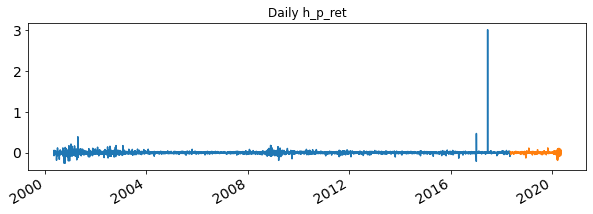

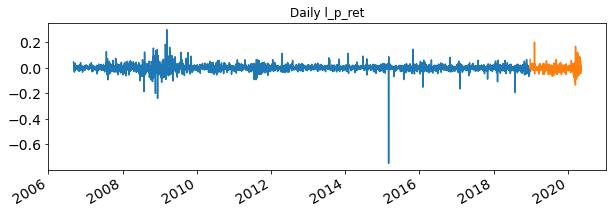

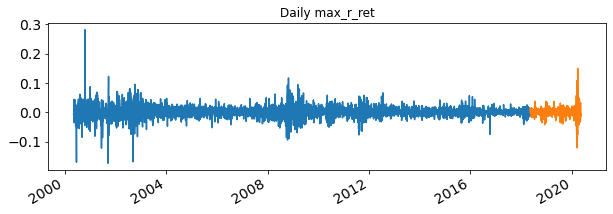

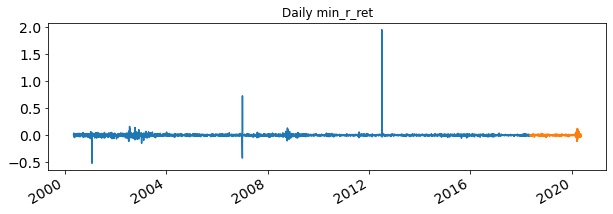

In [47]:
# highest_performance_stock
h_p_ret = ((highest_performance_stock.close.diff() + highest_performance_stock.dividend_amt.shift()\
             )/highest_performance_stock.close.shift()).bfill()
highest_performance_stock['ret'] = h_p_ret
h_Apart = int(len(highest_performance_stock)*9/10)
h_train = highest_performance_stock[0:h_Apart]
h_test = highest_performance_stock[h_Apart:]

# lowest_performance_stock
l_p_ret = ((lowest_performance_stock.close.diff() + lowest_performance_stock.dividend_amt.shift()\
             )/lowest_performance_stock.close.shift()).bfill()
lowest_performance_stock['ret'] = l_p_ret
l_Apart = int(len(lowest_performance_stock)*9/10)
l_train = lowest_performance_stock[0:l_Apart]
l_test = lowest_performance_stock[l_Apart:]

# max_rsquared_stock
max_rsq_ret = ((max_rsquared_stock.close.diff() + max_rsquared_stock.dividend_amt.shift()\
             )/max_rsquared_stock.close.shift()).bfill()
max_rsquared_stock['ret'] = max_rsq_ret
max_r_Apart = int(len(max_rsquared_stock)*9/10)
max_r_train = max_rsquared_stock[0:max_r_Apart]
max_r_test = max_rsquared_stock[max_r_Apart:]

# min_rsquared_stock
min_rsq_ret = ((min_rsquared_stock.close.diff() + min_rsquared_stock.dividend_amt.shift()\
             )/min_rsquared_stock.close.shift()).bfill()
min_rsquared_stock['ret'] = min_rsq_ret
min_r_Apart = int(len(min_rsquared_stock)*9/10)
min_r_train = min_rsquared_stock[0:min_r_Apart]
min_r_test = min_rsquared_stock[min_r_Apart:]

#Plotting data
h_train.ret.plot(figsize=(10,3), title= 'Daily h_p_ret', fontsize=14)
h_test.ret.plot(figsize=(10,3), title= 'Daily h_p_ret', fontsize=14)
plt.show()

l_train.ret.plot(figsize=(10,3), title= 'Daily l_p_ret', fontsize=14)
l_test.ret.plot(figsize=(10,3), title= 'Daily l_p_ret', fontsize=14)
plt.show()

max_r_train.ret.plot(figsize=(10,3), title= 'Daily max_r_ret', fontsize=14)
max_r_test.ret.plot(figsize=(10,3), title= 'Daily max_r_ret', fontsize=14)
plt.show()

min_r_train.ret.plot(figsize=(10,3), title= 'Daily min_r_ret', fontsize=14)
min_r_test.ret.plot(figsize=(10,3), title= 'Daily min_r_ret', fontsize=14)
plt.show()

## h_train

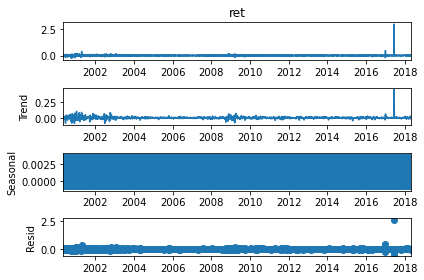

In [48]:
import statsmodels.api as sm
h_train.index.name = "Timestamp"
h_train_ret = h_train.ret
h_train_ret = h_train_ret.resample('D').fillna(method='ffill')
sm.tsa.seasonal_decompose(h_train_ret).plot()
result = sm.tsa.stattools.adfuller(h_train_ret)
plt.show()

## h_train_ret

E:\Anaconda3_files\envs\AIHUB\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


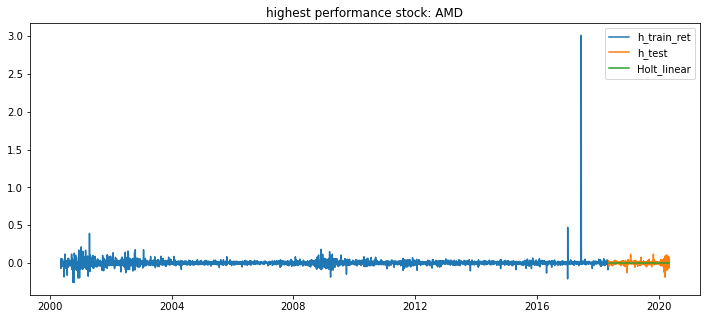

In [49]:
from statsmodels.tsa.api import Holt
 
y_hat_avg = h_test.copy()
 
fit = Holt(np.asarray(h_train_ret)).fit(smoothing_level=0.05, smoothing_slope=0.0)
y_hat_avg['Holt_linear'] = fit.forecast(len(h_test))

plt.figure(figsize=(12, 5))
plt.plot(h_train_ret, label='h_train_ret')
plt.plot(h_test.ret, label='h_test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title("highest performance stock: AMD")
plt.show()

## l_train

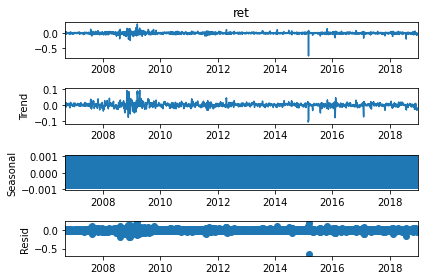

In [50]:
l_train.index.name = "Timestamp"
l_train_ret = l_train.ret
l_train_ret = l_train_ret.resample('D').fillna(method='ffill')
sm.tsa.seasonal_decompose(l_train_ret).plot()
result = sm.tsa.stattools.adfuller(l_train_ret)
plt.show()

## l_train_ret

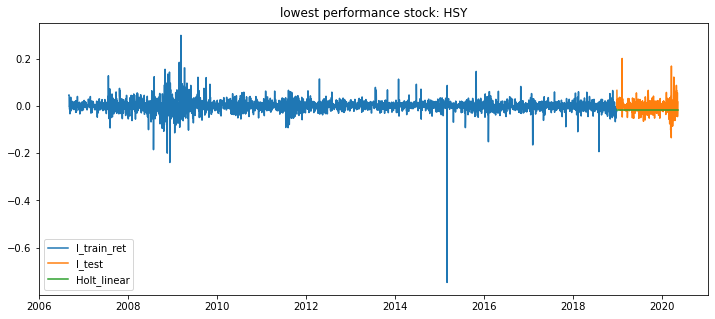

In [51]:
y_hat_avg = l_test.copy()
 
fit = Holt(np.asarray(l_train_ret)).fit(smoothing_level=0.05, smoothing_slope=0.0)
y_hat_avg['Holt_linear'] = fit.forecast(len(l_test))

plt.figure(figsize=(12, 5))
plt.plot(l_train_ret, label='l_train_ret')
plt.plot(l_test.ret, label='l_test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title("lowest performance stock: HSY")
plt.show()

## min_r_train


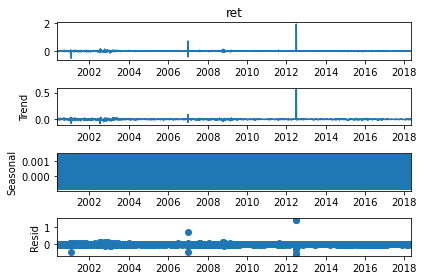

In [52]:
min_r_train.index.name = "Timestamp"
min_r_train_ret = min_r_train.ret
min_r_train_ret = min_r_train_ret.resample('D').fillna(method='ffill')
sm.tsa.seasonal_decompose(min_r_train_ret).plot()
result = sm.tsa.stattools.adfuller(min_r_train_ret)
plt.show()

## min_r_train_ret

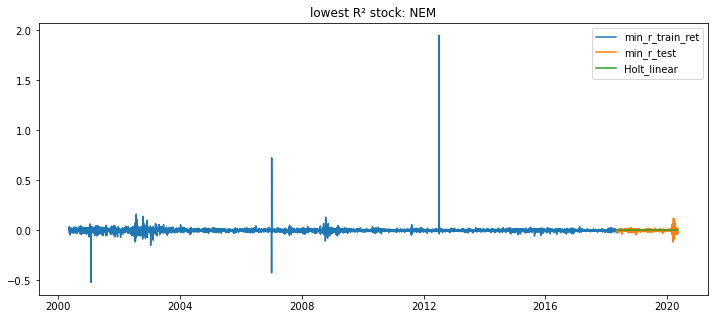

In [53]:
y_hat_avg = min_r_test.copy()

fit = Holt(np.asarray(min_r_train_ret)).fit(smoothing_level=0.05, smoothing_slope=0.0)
y_hat_avg['Holt_linear'] = fit.forecast(len(min_r_test))

plt.figure(figsize=(12, 5))
plt.plot(min_r_train_ret, label='min_r_train_ret')
plt.plot(min_r_test.ret, label='min_r_test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title("lowest R² stock: NEM")
plt.show()

## max_r_train

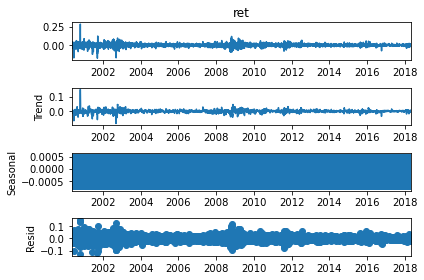

In [54]:
max_r_train.index.name = "Timestamp"
max_r_train_ret = max_r_train.ret
max_r_train_ret = max_r_train_ret.resample('D').fillna(method='ffill')
sm.tsa.seasonal_decompose(max_r_train_ret).plot()
result = sm.tsa.stattools.adfuller(max_r_train_ret)
plt.show()

## max_r_train_ret

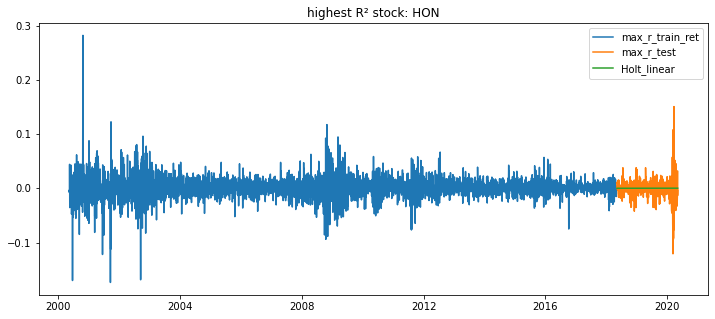

In [55]:
y_hat_avg = max_r_test.copy()

fit = Holt(np.asarray(max_r_train_ret)).fit(smoothing_level=0.05, smoothing_slope=0.0)
y_hat_avg['Holt_linear'] = fit.forecast(len(max_r_test))

plt.figure(figsize=(12, 5))
plt.plot(max_r_train_ret, label='max_r_train_ret')
plt.plot(max_r_test.ret, label='max_r_test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title("highest R² stock: HON")
plt.show()